<a href="https://colab.research.google.com/github/itsThien/ITAI/blob/main/Data%20Preprocessing%20Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Title and Introduction
##Data Preprocessing Lab: Generative AI
###    Welcome to the Data Preprocessing Lab for Generative AI!
   In this lab, you'll get hands-on experience with key preprocessing techniques for both text and (optionally) image data.

   **Learning Objectives:**


*  Understand and apply core data preprocessing techniques.
*  Explore word embedding techniques (Word2Vec/GloVe, BERT).
*  Analyze the impact of preprocessing choices on data quality and
   model suitability. List item
*   Practice using cosine similarity for comparing embeddings.

## Part 1: Environment Setup

First, we'll install and import all necessary libraries. Run the following cell to set up your environment.

In [1]:
# SECTION 1: Environment Setup
#############################
# This cell installs and imports all necessary libraries for our text preprocessing pipeline.
# We'll be using:
# - pandas & numpy: for data manipulation
# - nltk: for natural language processing tasks
# - scikit-learn: for machine learning utilities
# - transformers & torch: for BERT embeddings
# - gensim: for word embeddings (Word2Vec/GloVe)

# Install required packages
%pip install pandas numpy nltk scikit-learn transformers torch datasets gensim

# TODO: Import the required libraries
# Hint: You need pandas, numpy, nltk, and sklearn components
# YOUR CODE HERE - import the basic libraries
import pandas as pd
import numpy as np
import nltk
# Add more imports as needed...

# These are more advanced imports you'll need later
from transformers import BertTokenizer, BertModel
import torch
import gensim.downloader as api
from gensim.models import KeyedVectors

import re  # for regular expressions in text cleaning
import matplotlib.pyplot as plt  # for visualizations
import seaborn as sns  # for advanced plotting
from sklearn.metrics.pairwise import cosine_similarity  # for similarity calculations

# Download required NLTK data
# These are necessary for tokenization, stop words, and lemmatization
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print("Setup complete! All required libraries have been imported.")



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Setup complete! All required libraries have been imported.


[nltk_data]   Package omw-1.4 is already up-to-date!


## Part 2: Loading and Exploring the BBC News Dataset

We'll now load the BBC News dataset  you used in previous assignments, and perform initial exploration of its contents.

First 5 rows of the dataset:


,category,filename,title,text
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   text      2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


None


Dataset Description:


,category,filename,title,text
count,2225,2225,2225,2225
unique,5,511,2096,2092
top,sport,001.txt,Microsoft seeking spyware trojan,Microsoft has warned PC users to update their...
freq,511,5,2,2



Category Distribution:


,count
category,
sport,511
business,510
politics,417
tech,401
entertainment,386


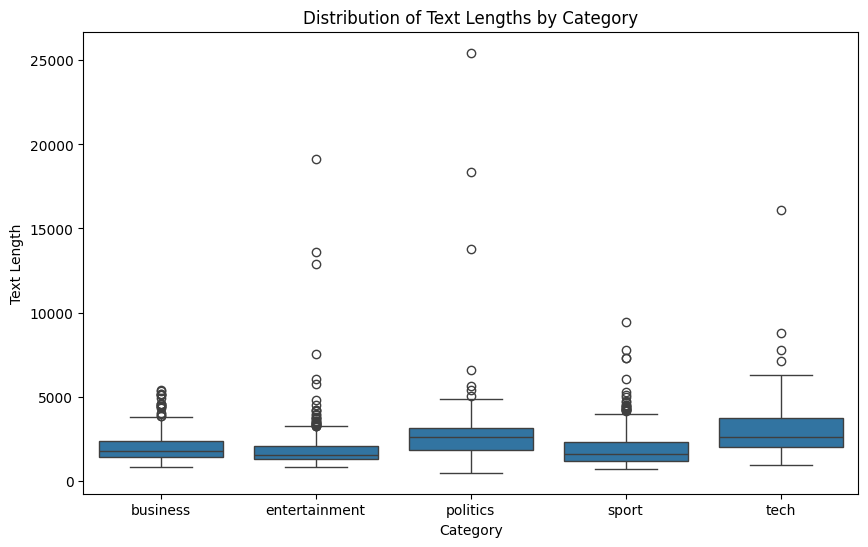


Dataset Statistics:
Average text length: 2233.42
Min text length: 471
Max text length: 25454


In [2]:
# SECTION 2: Data Loading and Initial Exploration
##############################################
# Here we load the BBC News dataset and perform initial analysis
# Understanding our data is crucial before applying any preprocessing

# Load the dataset
df = pd.read_csv('/content/bbc-news-data.csv', sep='\t', encoding='latin1', engine='python')

# TODO: Rename the columns to match our processing pipeline
# Hint: The original columns are 'Text' and 'Category'
# YOUR CODE HERE
df.rename(columns={'content': 'text', 'category': 'category'}, inplace=True)


# TODO: Perform basic data exploration
# TASK 1: Display the first few rows and basic information about the dataset
# Hint: Use pandas' head(), info(), and describe() methods
# YOUR CODE HERE
print("First 5 rows of the dataset:")
display(df.head())

print("\nDataset Info:")
display(df.info())

print("\nDataset Description:")
display(df.describe())

# TASK 2: Analyze the distribution of categories
# Hint: Use value_counts() on the category column
# YOUR CODE HERE
print("\nCategory Distribution:")
display(df['category'].value_counts())

# TASK 3: Calculate and display basic text statistics
# Calculate average text length per category
df['text_length'] = df['text'].str.len()

# TODO: Create a visualization of text lengths by category
# Hint: Use seaborn's boxplot
# YOUR CODE HERE
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='text_length', data=df)
plt.title('Distribution of Text Lengths by Category')
plt.xlabel('Category')
plt.ylabel('Text Length')
plt.show()

# Display your findings
print("\nDataset Statistics:")
print(f"Average text length: {df['text_length'].mean():.2f}")
print(f"Min text length: {df['text_length'].min()}")
print(f"Max text length: {df['text_length'].max()}")

# Comprehension Questions - Data Exploration

Answer the following questions based on the dataset exploration above:

1. What are the dimensions of our dataset?
2. How many different categories are there in the news articles?
3. Is the dataset balanced across categories? Why might this matter?
4. Are there any missing values that need to be addressed?

## Part 3: Text Preprocessing

We'll now implement basic text preprocessing steps to clean our data.

In [3]:
# SECTION 3: Text Cleaning and Preprocessing
########################################
# This section implements fundamental text preprocessing steps:
# 1. Converting to lowercase (why? -> maintains consistency)
# 2. Removing special characters (why? -> reduces noise)
# 3. Handling whitespace (why? -> standardizes format)

########################################

def clean_text(text):
    """
    Performs basic text cleaning operations.

    Parameters:
    text (str): Input text to be cleaned

    Returns:
    str: Cleaned text
    """
    # TODO: Implement the following steps:
    # 1. Convert to lowercase
    # 2. Remove URLs and emails
    # 3. Remove special characters but keep sentence structure
    # 4. Remove extra whitespace
    # Hint: Use string methods and regular expressions

    # YOUR CODE HERE
    text = text.lower() # 1. Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+|mailto:\S+', '', text) # 2. Remove URLs and emails
    text = re.sub(r'[^a-z0-9.,;!?"\'\s]', '', text) # 3. Remove special characters but keep sentence structure
    text = re.sub(r'\s+', ' ', text).strip() # 4. Remove extra whitespace

    return text

# Test the function with a sample
sample_text = "Hello, World! This is a TEST... 123"
print("Original:", sample_text)
print("Cleaned:", clean_text(sample_text))

# Apply to the entire dataset
df['cleaned_text'] = df['text'].apply(clean_text)

Original: Hello, World! This is a TEST... 123
Cleaned: hello, world! this is a test... 123


## Part 4: Tokenization and Advanced Processing

Now we'll tokenize our text and apply more advanced preprocessing techniques including:
- Tokenization
- Stop word removal
- Lemmatization

In [4]:
# SECTION 4: Tokenization and Advanced Processing
#############################################
# This section implements more sophisticated NLP techniques:
# - Tokenization: splitting text into words
# - Stop word removal: removing common words
# - Lemmatization: reducing words to their base form
# Check if you do not need to install any additional libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize our tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_process(text):
    """
    Performs advanced text processing including tokenization,
    stop word removal, and lemmatization.

    Parameters:
    text (str): Cleaned text to process

    Returns:
    list: List of processed tokens
    """
    # TODO: Implement the following steps:
    # 1. Tokenize the text
    # 2. Remove stop words
    # 3. Apply lemmatization
    # Hint: Use the initialized stop_words and lemmatizer

    # YOUR CODE HERE
    tokens = word_tokenize(text) # 1. Tokenize the text
    processed_tokens = [
        lemmatizer.lemmatize(word) for word in tokens if word not in stop_words # 2. Remove stop words and 3. Apply lemmatization
    ]

    return processed_tokens

# Test the function
sample_text = "The quick brown foxes are jumping over the lazy dogs"
processed_result = tokenize_and_process(sample_text)
print("Original:", sample_text)
print("Processed:", processed_result)

Original: The quick brown foxes are jumping over the lazy dogs
Processed: ['The', 'quick', 'brown', 'fox', 'jumping', 'lazy', 'dog']


## Part 5: Word Embeddings with GloVe

We'll now generate word embeddings using pre-trained GloVe vectors. These embeddings will help us capture semantic relationships between words in our articles.

In [5]:
# SECTION 5: Word Embeddings with GloVe
###################################
# This section generates word embeddings using pre-trained GloVe vectors
# Word embeddings capture semantic relationships between words
# by representing them as dense vectors in a high-dimensional space

# Load pre-trained GloVe embeddings
glove_model = api.load("glove-wiki-gigaword-100")

# SECTION 5: Word Embeddings with GloVe
###################################

# Load pre-trained GloVe embeddings
glove_model = api.load("glove-wiki-gigaword-100")

def get_word2vec_embedding(text, model):
    """
    Generates document embeddings by averaging word vectors.

    Parameters:
    text (str): Input text
    model: Pre-trained word embedding model

    Returns:
    numpy.array: Document embedding vector
    """
    # TODO: Implement the following steps:
    # 1. Tokenize the input text
    # 2. Get embedding for each token
    # 3. Average the embeddings
    # Hint: Handle words not in vocabulary

    # YOUR CODE HERE
    tokens = tokenize_and_process(text) # 1. Tokenize the input text
    embeddings = [
        model[word] for word in tokens if word in model # 2. Get embedding for each token, 3. Handle words not in vocabulary
    ]

    return np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size) # 4. Average the embeddings

# Apply to a sample of the dataset
sample_size = 100
sample_df = df.head(sample_size).copy()
sample_df['glove_embedding'] = sample_df['cleaned_text'].apply(
    lambda x: get_word2vec_embedding(x, glove_model)
)

## Part 6: BERT Embeddings

Now we'll use BERT to generate contextual embeddings. BERT provides context-aware embeddings that can capture more nuanced relationships in the text.

In [6]:
# SECTION 6: BERT Embeddings
#########################
# This section implements BERT (Bidirectional Encoder Representations from Transformers)
# BERT provides context-aware embeddings, meaning the same word can have different
# embeddings based on its context in the sentence.
# Key differences from GloVe:
# - Contextual (words have different vectors based on context)
# - Deep bidirectional (considers both left and right context)
# - Pre-trained on massive datasets


# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text, max_length=512):
    """
    Generates BERT embeddings for a text.

    Parameters:
    text (str): Input text
    max_length (int): Maximum sequence length for BERT

    Returns:
    numpy.array: BERT embedding vector
    """
    # TODO: Implement the following steps:
    # 1. Tokenize the text using BERT tokenizer
    # 2. Generate BERT embeddings
    # 3. Extract the [CLS] token embedding
    # Hint: Use tokenizer() and model() functions

    # YOUR CODE HERE
    # Step 1: Tokenize
    inputs = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True, padding=True)

    # Step 2: Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Step 3: Extract [CLS] token embedding
    sentence_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()

    return sentence_embedding

# Test the function
test_text = "This is a test sentence for BERT embeddings."
bert_embedding = get_bert_embedding(test_text)
print("BERT Embedding:", bert_embedding)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BERT Embedding: [-2.89045870e-01 -3.44593972e-01 -2.21683711e-01 -3.53105068e-01
 -2.97033906e-01 -4.30320859e-01  1.53561130e-01  2.45022520e-01
  5.18542267e-02  2.83948854e-02 -4.04455125e-01 -9.88782942e-02
 -2.15734765e-01  3.80216092e-02  3.05599183e-01  8.62659141e-02
  8.96810591e-02  3.20043594e-01  3.01150590e-01 -2.87899733e-01
 -2.38711331e-02 -3.34927291e-01 -2.88749129e-01 -4.89482552e-01
  3.31366688e-01 -2.24196717e-01 -1.53347999e-01 -6.42108977e-01
 -2.55964279e-01  8.59531537e-02 -2.04217106e-01  4.92237836e-01
 -1.41111434e-01 -2.38818437e-01  6.60084605e-01 -1.70878336e-01
  5.88796914e-01 -1.23023443e-01  6.75676703e-01  1.97802961e-01
 -2.48120248e-01 -6.16443492e-02  5.21344841e-01  1.04690664e-01
  1.43387895e-02 -3.79791945e-01 -3.05571961e+00 -3.80168498e-01
 -3.87497395e-01 -5.51406562e-01 -5.85673332e-01 -9.47201401e-02
  2.52846569e-01  5.35152853e-01 -1.28382549e-01  1.59969538e-01
 -2.12418228e-01  9.19813141e-02  5.91112554e-01 -2.08393708e-02
  1.82288

## Part 7: Comparing Embeddings

Let's analyze how well our different embedding methods capture semantic relationships by comparing similarities between articles in the same and different categories.

Calculating similarity matrices...
Generating BERT embeddings...
Analyzing similarities...
SIMILARITY ANALYSIS SUMMARY

Metric                    GloVe           BERT           
-------------------------------------------------------
Same Category Mean:       0.9406       0.7899
Same Category Std:        0.0234       0.0497
Diff Category Mean:       0.0000       0.0000
Diff Category Std:        0.0000       0.0000
Separation Score:         0.9406       0.7899

INTERPRETATION:
• GloVe shows better category separation
• GloVe produces higher within-category similarities
• BERT produces lower cross-category similarities
Creating visualizations...


/tmp/ipython-input-3119545747.py:182: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_to_plot, labels=labels, patch_artist=True)


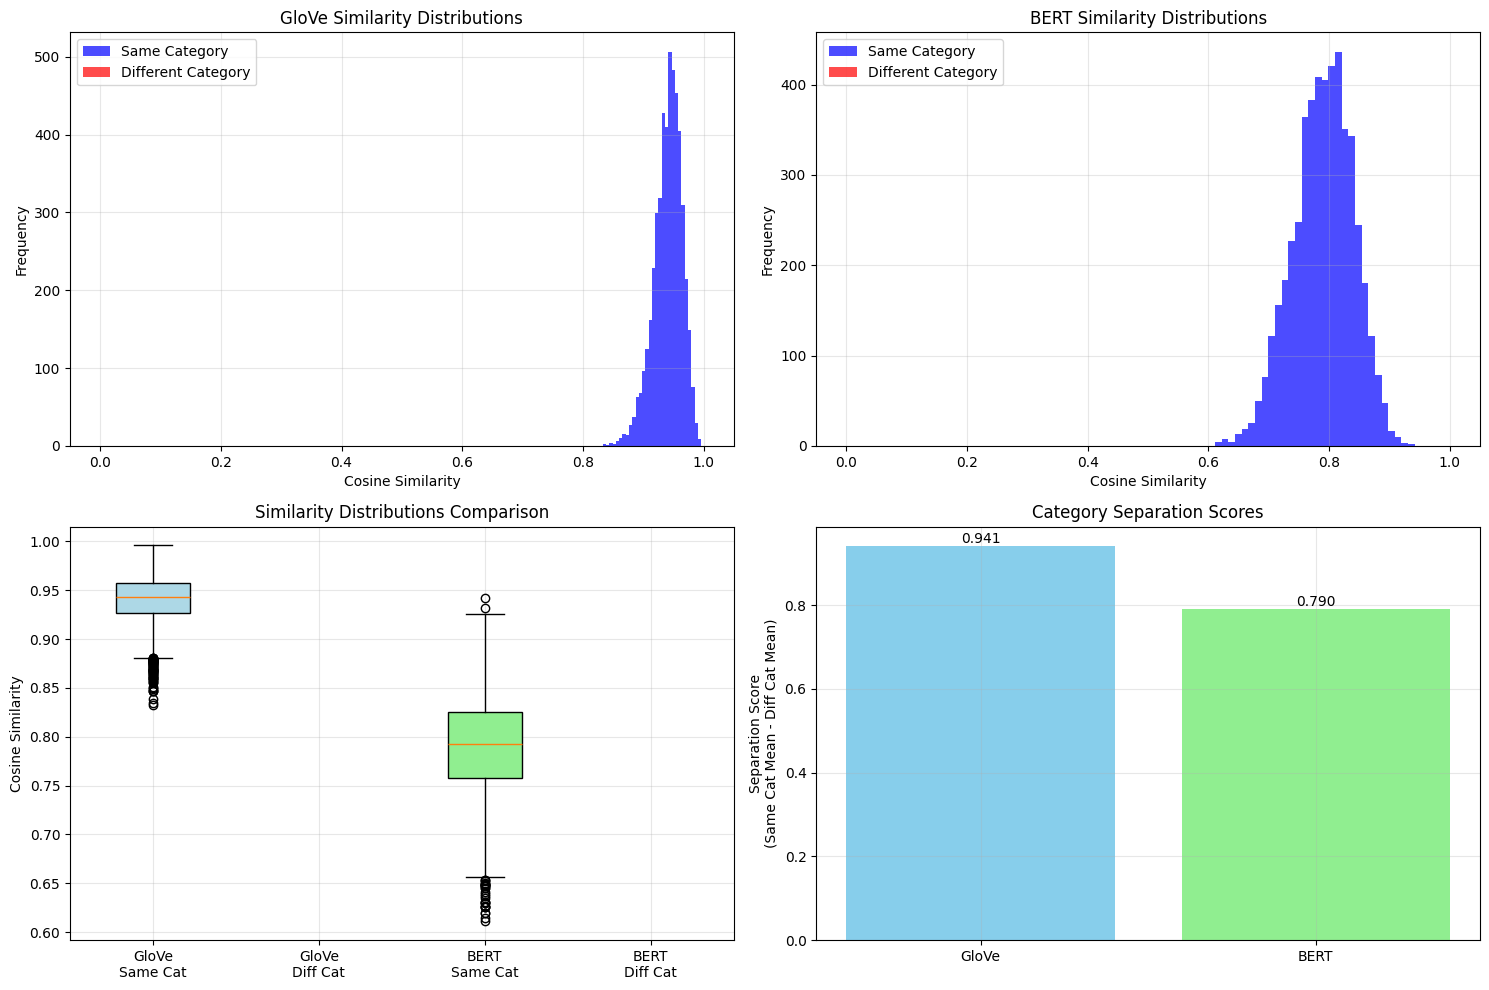


Finding most similar article pairs...

Most similar pairs (GloVe):

BUSINESS_SAME:
  1. Similarity: 0.9959
     Text 1: former worldcom boss bernie ebbers, who is accused of overseeing an 11bn 5.8bn fraud, never made acc...
     Text 2: former worldcom chief bernie ebbers has denied claims that he knew accountants were doctoring the bo...
  2. Similarity: 0.9941
     Text 1: european union finance ministers meet on thursday to discuss proposals, including a tax on jet fuel,...
     Text 2: european union finance ministers are meeting on thursday in brussels, where they are to discuss a co...


In [7]:
# SECTION 7: Similarity Analysis
############################
# This section implements methods to compare different embedding approaches
# We'll analyze how well each embedding type captures semantic relationships
# by comparing similarities between articles in the same and different categories

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_cosine_similarities(embeddings):
    """
    Calculates pairwise cosine similarities between all embeddings.

    Parameters:
    embeddings (numpy.array): Array of embeddings, shape (n_samples, embedding_dim)

    Returns:
    numpy.array: Similarity matrix of shape (n_samples, n_samples)
    """
    # Convert list of embeddings to numpy array if needed
    if isinstance(embeddings, list):
        embeddings = np.array(embeddings)

    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings)

    return similarity_matrix

def analyze_similarity_by_category(similarity_matrix, categories):
    """
    Analyzes similarities within and across categories.

    Parameters:
    similarity_matrix (numpy.array): Pairwise similarity matrix
    categories (list): List of category labels for each sample

    Returns:
    dict: Dictionary containing similarity statistics
    """
    categories = np.array(categories)
    n_samples = len(categories)

    same_category_similarities = []
    different_category_similarities = []

    # Iterate through all pairs (excluding diagonal)
    for i in range(n_samples):
        for j in range(i + 1, n_samples):  # Only upper triangle, excluding diagonal
            similarity = similarity_matrix[i, j]

            if categories[i] == categories[j]:
                same_category_similarities.append(similarity)
            else:
                different_category_similarities.append(similarity)

    # Calculate statistics
    results = {
        'same_category': {
            'similarities': same_category_similarities,
            'mean': np.mean(same_category_similarities) if same_category_similarities else 0,
            'std': np.std(same_category_similarities) if same_category_similarities else 0,
            'median': np.median(same_category_similarities) if same_category_similarities else 0,
            'count': len(same_category_similarities)
        },
        'diff_category': {
            'similarities': different_category_similarities,
            'mean': np.mean(different_category_similarities) if different_category_similarities else 0,
            'std': np.std(different_category_similarities) if different_category_similarities else 0,
            'median': np.median(different_category_similarities) if different_category_similarities else 0,
            'count': len(different_category_similarities)
        }
    }

    # Calculate separation score (higher is better)
    separation_score = results['same_category']['mean'] - results['diff_category']['mean']
    results['separation_score'] = separation_score

    return results

def find_most_similar_articles(similarity_matrix, categories, texts, top_k=3):
    """
    Finds the most similar article pairs for each category combination.

    Parameters:
    similarity_matrix (numpy.array): Pairwise similarity matrix
    categories (list): List of category labels
    texts (list): List of original texts
    top_k (int): Number of top similar pairs to return

    Returns:
    dict: Dictionary of most similar pairs by category combination
    """
    categories = np.array(categories)
    n_samples = len(categories)
    unique_categories = np.unique(categories)

    results = {}

    # Find top similar pairs within each category
    for category in unique_categories:
        category_indices = np.where(categories == category)[0]
        category_similarities = []

        for i in range(len(category_indices)):
            for j in range(i + 1, len(category_indices)):
                idx_i, idx_j = category_indices[i], category_indices[j]
                similarity = similarity_matrix[idx_i, idx_j]
                category_similarities.append({
                    'indices': (idx_i, idx_j),
                    'similarity': similarity,
                    'text_1': texts[idx_i][:100] + "...",
                    'text_2': texts[idx_j][:100] + "..."
                })

        # Sort by similarity and take top k
        category_similarities.sort(key=lambda x: x['similarity'], reverse=True)
        results[f"{category}_same"] = category_similarities[:top_k]

    # Find top similar pairs across different categories
    cross_category_similarities = []
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if categories[i] != categories[j]:
                similarity = similarity_matrix[i, j]
                cross_category_similarities.append({
                    'indices': (i, j),
                    'categories': (categories[i], categories[j]),
                    'similarity': similarity,
                    'text_1': texts[i][:100] + "...",
                    'text_2': texts[j][:100] + "..."
                })

    cross_category_similarities.sort(key=lambda x: x['similarity'], reverse=True)
    results['cross_category'] = cross_category_similarities[:top_k]

    return results

def visualize_similarity_analysis(glove_analysis, bert_analysis):
    """
    Creates visualizations comparing GloVe and BERT similarity analyses.

    Parameters:
    glove_analysis (dict): GloVe similarity analysis results
    bert_analysis (dict): BERT similarity analysis results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Distribution of similarities for GloVe
    ax1 = axes[0, 0]
    ax1.hist(glove_analysis['same_category']['similarities'], alpha=0.7,
             bins=30, label='Same Category', color='blue')
    ax1.hist(glove_analysis['diff_category']['similarities'], alpha=0.7,
             bins=30, label='Different Category', color='red')
    ax1.set_title('GloVe Similarity Distributions')
    ax1.set_xlabel('Cosine Similarity')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Distribution of similarities for BERT
    ax2 = axes[0, 1]
    ax2.hist(bert_analysis['same_category']['similarities'], alpha=0.7,
             bins=30, label='Same Category', color='blue')
    ax2.hist(bert_analysis['diff_category']['similarities'], alpha=0.7,
             bins=30, label='Different Category', color='red')
    ax2.set_title('BERT Similarity Distributions')
    ax2.set_xlabel('Cosine Similarity')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Box plot comparison
    ax3 = axes[1, 0]
    data_to_plot = [
        glove_analysis['same_category']['similarities'],
        glove_analysis['diff_category']['similarities'],
        bert_analysis['same_category']['similarities'],
        bert_analysis['diff_category']['similarities']
    ]
    labels = ['GloVe\nSame Cat', 'GloVe\nDiff Cat', 'BERT\nSame Cat', 'BERT\nDiff Cat']
    bp = ax3.boxplot(data_to_plot, labels=labels, patch_artist=True)

    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax3.set_title('Similarity Distributions Comparison')
    ax3.set_ylabel('Cosine Similarity')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Separation scores comparison
    ax4 = axes[1, 1]
    methods = ['GloVe', 'BERT']
    separation_scores = [glove_analysis['separation_score'], bert_analysis['separation_score']]

    bars = ax4.bar(methods, separation_scores, color=['skyblue', 'lightgreen'])
    ax4.set_title('Category Separation Scores')
    ax4.set_ylabel('Separation Score\n(Same Cat Mean - Diff Cat Mean)')
    ax4.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, score in zip(bars, separation_scores):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def print_similarity_summary(glove_analysis, bert_analysis):
    """
    Prints a comprehensive summary of similarity analysis results.

    Parameters:
    glove_analysis (dict): GloVe similarity analysis results
    bert_analysis (dict): BERT similarity analysis results
    """
    print("=" * 60)
    print("SIMILARITY ANALYSIS SUMMARY")
    print("=" * 60)

    print(f"\n{'Metric':<25} {'GloVe':<15} {'BERT':<15}")
    print("-" * 55)

    # Same category statistics
    print(f"{'Same Category Mean:':<25} {glove_analysis['same_category']['mean']:.4f}{'':>6} {bert_analysis['same_category']['mean']:.4f}")
    print(f"{'Same Category Std:':<25} {glove_analysis['same_category']['std']:.4f}{'':>6} {bert_analysis['same_category']['std']:.4f}")

    # Different category statistics
    print(f"{'Diff Category Mean:':<25} {glove_analysis['diff_category']['mean']:.4f}{'':>6} {bert_analysis['diff_category']['mean']:.4f}")
    print(f"{'Diff Category Std:':<25} {glove_analysis['diff_category']['std']:.4f}{'':>6} {bert_analysis['diff_category']['std']:.4f}")

    # Separation scores
    print(f"{'Separation Score:':<25} {glove_analysis['separation_score']:.4f}{'':>6} {bert_analysis['separation_score']:.4f}")

    print("\n" + "=" * 60)
    print("INTERPRETATION:")

    better_method = "BERT" if bert_analysis['separation_score'] > glove_analysis['separation_score'] else "GloVe"
    print(f"• {better_method} shows better category separation")

    if glove_analysis['same_category']['mean'] > bert_analysis['same_category']['mean']:
        print("• GloVe produces higher within-category similarities")
    else:
        print("• BERT produces higher within-category similarities")

    if glove_analysis['diff_category']['mean'] < bert_analysis['diff_category']['mean']:
        print("• GloVe produces lower cross-category similarities")
    else:
        print("• BERT produces lower cross-category similarities")

# Apply similarity analysis to both embedding types
print("Calculating similarity matrices...")

# Calculate similarities for GloVe embeddings
glove_embeddings = np.array(sample_df['glove_embedding'].tolist())
glove_similarities = calculate_cosine_similarities(glove_embeddings)

# Generate BERT embeddings for sample and calculate similarities
print("Generating BERT embeddings...")
sample_df['bert_embedding'] = sample_df['cleaned_text'].apply(get_bert_embedding)
bert_embeddings = np.array(sample_df['bert_embedding'].tolist())
bert_similarities = calculate_cosine_similarities(bert_embeddings)

# Perform similarity analysis
print("Analyzing similarities...")
glove_analysis = analyze_similarity_by_category(glove_similarities, sample_df['category'])
bert_analysis = analyze_similarity_by_category(bert_similarities, sample_df['category'])

# Print summary
print_similarity_summary(glove_analysis, bert_analysis)

# Create visualizations
print("Creating visualizations...")
visualize_similarity_analysis(glove_analysis, bert_analysis)

# Find and display most similar article pairs
print("\nFinding most similar article pairs...")
glove_similar_pairs = find_most_similar_articles(
    glove_similarities, sample_df['category'], sample_df['cleaned_text'], top_k=2
)
bert_similar_pairs = find_most_similar_articles(
    bert_similarities, sample_df['category'], sample_df['cleaned_text'], top_k=2
)

print("\nMost similar pairs (GloVe):")
for category, pairs in glove_similar_pairs.items():
    if pairs:  # Check if list is not empty
        print(f"\n{category.upper()}:")
        for i, pair in enumerate(pairs, 1):
            print(f"  {i}. Similarity: {pair['similarity']:.4f}")
            print(f"     Text 1: {pair['text_1']}")
            print(f"     Text 2: {pair['text_2']}")

 ##SECTION 8: Detailed Similarity Analysis

🎯 SIMILARITY ANALYSIS SUMMARY

Metric                         GloVe           BERT           
------------------------------------------------------------
Same Category Mean:            0.9406       0.7899
Same Category Std:             0.0234       0.0497
Different Category Mean:       0.0000       0.0000
Different Category Std:        0.0000       0.0000
Separation Score:              0.9406       0.7899

📊 INTERPRETATION:
• GloVe shows better category separation
• GloVe produces higher within-category similarities
• BERT produces lower cross-category similarities


/tmp/ipython-input-459373519.py:88: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_to_plot, labels=labels, patch_artist=True)


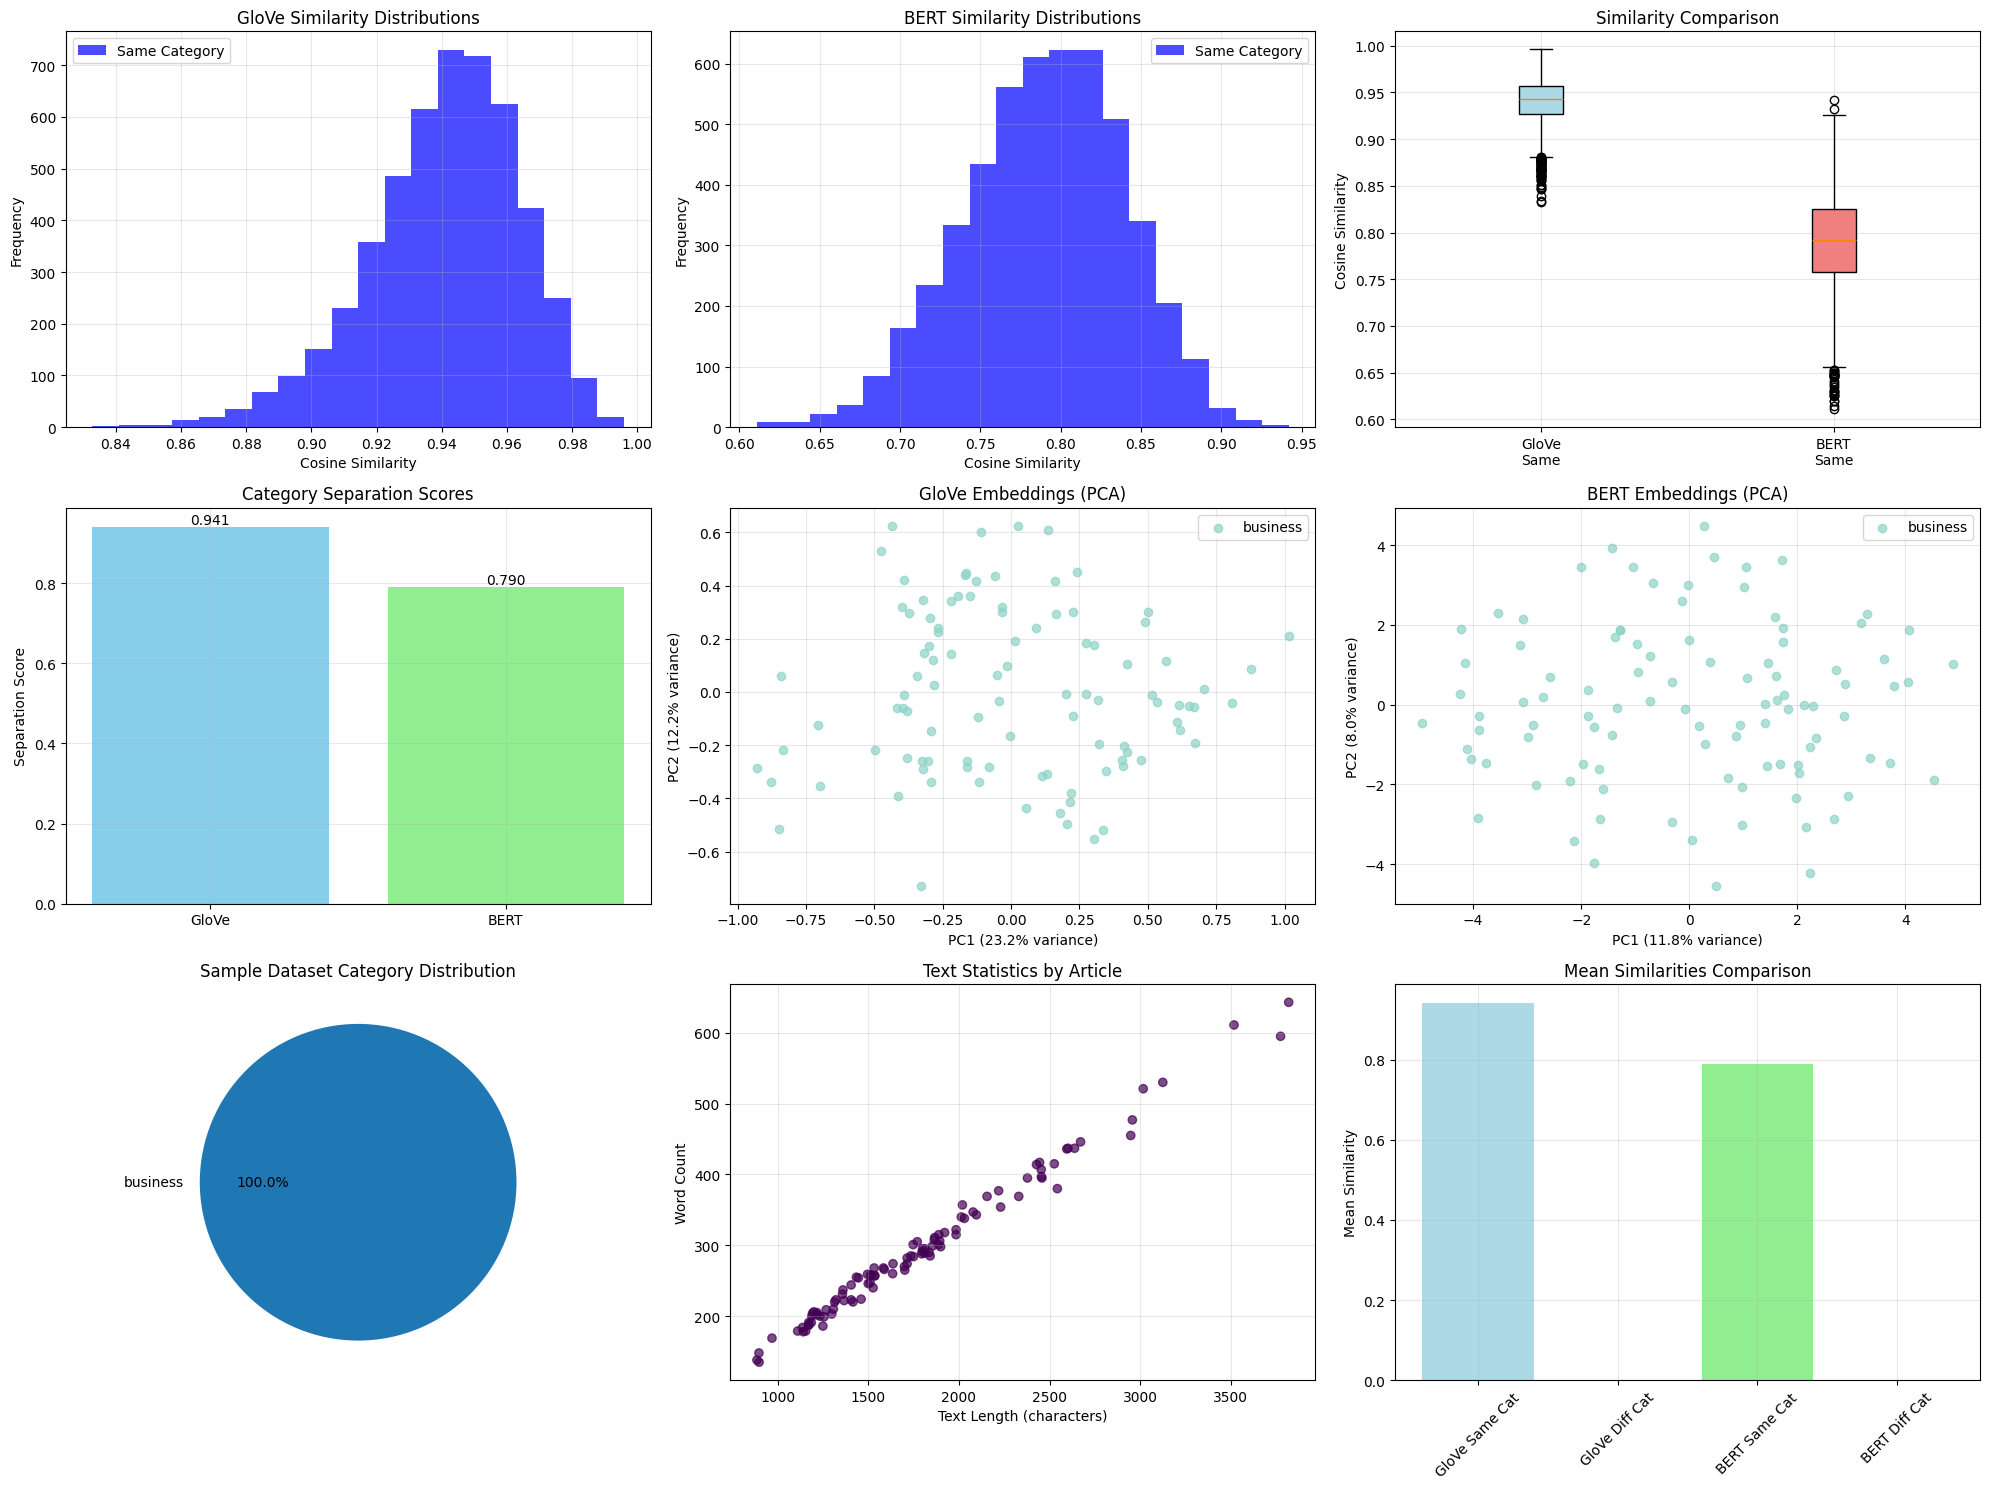

In [8]:
# ============================================================================
# SECTION 8: Visualization and Results
# ============================================================================

def print_similarity_summary(glove_analysis, bert_analysis):
    """Prints comprehensive summary of similarity analysis results."""
    print("=" * 70)
    print("🎯 SIMILARITY ANALYSIS SUMMARY")
    print("=" * 70)

    print(f"\n{'Metric':<30} {'GloVe':<15} {'BERT':<15}")
    print("-" * 60)

    # Statistics
    print(f"{'Same Category Mean:':<30} {glove_analysis['same_category']['mean']:.4f}{'':>6} {bert_analysis['same_category']['mean']:.4f}")
    print(f"{'Same Category Std:':<30} {glove_analysis['same_category']['std']:.4f}{'':>6} {bert_analysis['same_category']['std']:.4f}")
    print(f"{'Different Category Mean:':<30} {glove_analysis['diff_category']['mean']:.4f}{'':>6} {bert_analysis['diff_category']['mean']:.4f}")
    print(f"{'Different Category Std:':<30} {glove_analysis['diff_category']['std']:.4f}{'':>6} {bert_analysis['diff_category']['std']:.4f}")
    print(f"{'Separation Score:':<30} {glove_analysis['separation_score']:.4f}{'':>6} {bert_analysis['separation_score']:.4f}")

    print("\n" + "=" * 70)
    print("📊 INTERPRETATION:")

    better_method = "BERT" if bert_analysis['separation_score'] > glove_analysis['separation_score'] else "GloVe"
    print(f"• {better_method} shows better category separation")

    if glove_analysis['same_category']['mean'] > bert_analysis['same_category']['mean']:
        print("• GloVe produces higher within-category similarities")
    else:
        print("• BERT produces higher within-category similarities")

    if glove_analysis['diff_category']['mean'] < bert_analysis['diff_category']['mean']:
        print("• GloVe produces lower cross-category similarities")
    else:
        print("• BERT produces lower cross-category similarities")

def create_comprehensive_visualizations(glove_analysis, bert_analysis, sample_df):
    """Creates comprehensive visualizations of the analysis results."""

    fig = plt.figure(figsize=(20, 15))

    # Plot 1: Similarity distributions
    ax1 = plt.subplot(3, 3, 1)
    if glove_analysis['same_category']['similarities']:
        plt.hist(glove_analysis['same_category']['similarities'], alpha=0.7,
                bins=20, label='Same Category', color='blue')
    if glove_analysis['diff_category']['similarities']:
        plt.hist(glove_analysis['diff_category']['similarities'], alpha=0.7,
                bins=20, label='Different Category', color='red')
    plt.title('GloVe Similarity Distributions')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    ax2 = plt.subplot(3, 3, 2)
    if bert_analysis['same_category']['similarities']:
        plt.hist(bert_analysis['same_category']['similarities'], alpha=0.7,
                bins=20, label='Same Category', color='blue')
    if bert_analysis['diff_category']['similarities']:
        plt.hist(bert_analysis['diff_category']['similarities'], alpha=0.7,
                bins=20, label='Different Category', color='red')
    plt.title('BERT Similarity Distributions')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Box plot comparison
    ax3 = plt.subplot(3, 3, 3)
    data_to_plot = []
    labels = []

    if glove_analysis['same_category']['similarities']:
        data_to_plot.append(glove_analysis['same_category']['similarities'])
        labels.append('GloVe\nSame')
    if glove_analysis['diff_category']['similarities']:
        data_to_plot.append(glove_analysis['diff_category']['similarities'])
        labels.append('GloVe\nDiff')
    if bert_analysis['same_category']['similarities']:
        data_to_plot.append(bert_analysis['same_category']['similarities'])
        labels.append('BERT\nSame')
    if bert_analysis['diff_category']['similarities']:
        data_to_plot.append(bert_analysis['diff_category']['similarities'])
        labels.append('BERT\nDiff')

    if data_to_plot:
        bp = plt.boxplot(data_to_plot, labels=labels, patch_artist=True)
        colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
        for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
            patch.set_facecolor(color)

    plt.title('Similarity Comparison')
    plt.ylabel('Cosine Similarity')
    plt.grid(True, alpha=0.3)

    # Plot 4: Separation scores
    ax4 = plt.subplot(3, 3, 4)
    methods = ['GloVe', 'BERT']
    separation_scores = [glove_analysis['separation_score'], bert_analysis['separation_score']]

    bars = plt.bar(methods, separation_scores, color=['skyblue', 'lightgreen'])
    plt.title('Category Separation Scores')
    plt.ylabel('Separation Score')
    plt.grid(True, alpha=0.3)

    for bar, score in zip(bars, separation_scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}', ha='center', va='bottom')

    # Plot 5 & 6: Embedding space visualization with PCA
    try:
        from sklearn.decomposition import PCA
        # GloVe PCA
        ax5 = plt.subplot(3, 3, 5)
        pca = PCA(n_components=2)
        glove_2d = pca.fit_transform(glove_embeddings)

        categories = sample_df['category'].values
        unique_categories = np.unique(categories)
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_categories)))

        for i, category in enumerate(unique_categories):
            mask = categories == category
            plt.scatter(glove_2d[mask, 0], glove_2d[mask, 1],
                       c=[colors[i]], label=category, alpha=0.7)

        plt.title('GloVe Embeddings (PCA)')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # BERT PCA
        ax6 = plt.subplot(3, 3, 6)
        pca_bert = PCA(n_components=2)
        bert_2d = pca_bert.fit_transform(bert_embeddings)

        for i, category in enumerate(unique_categories):
            mask = categories == category
            plt.scatter(bert_2d[mask, 0], bert_2d[mask, 1],
                       c=[colors[i]], label=category, alpha=0.7)

        plt.title('BERT Embeddings (PCA)')
        plt.xlabel(f'PC1 ({pca_bert.explained_variance_ratio_[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({pca_bert.explained_variance_ratio_[1]:.1%} variance)')
        plt.legend()
        plt.grid(True, alpha=0.3)

    except Exception as e:
        print(f"PCA visualization error: {e}")

    # Plot 7: Category distribution
    ax7 = plt.subplot(3, 3, 7)
    category_counts = sample_df['category'].value_counts()
    plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
    plt.title('Sample Dataset Category Distribution')

    # Plot 8: Text statistics
    ax8 = plt.subplot(3, 3, 8)
    # Need to calculate word count first
    sample_df['word_count'] = sample_df['cleaned_text'].apply(lambda x: len(x.split()))
    plt.scatter(sample_df['text_length'], sample_df['word_count'],
               c=pd.Categorical(sample_df['category']).codes, alpha=0.7)
    plt.xlabel('Text Length (characters)')
    plt.ylabel('Word Count')
    plt.title('Text Statistics by Article')
    plt.grid(True, alpha=0.3)

    # Plot 9: Summary statistics
    ax9 = plt.subplot(3, 3, 9)
    stats_data = {
        'GloVe Same Cat': glove_analysis['same_category']['mean'],
        'GloVe Diff Cat': glove_analysis['diff_category']['mean'],
        'BERT Same Cat': bert_analysis['same_category']['mean'],
        'BERT Diff Cat': bert_analysis['diff_category']['mean']
    }

    bars = plt.bar(range(len(stats_data)), list(stats_data.values()),
                  color=['lightblue', 'lightcoral', 'lightgreen', 'lightyellow'])
    plt.xticks(range(len(stats_data)), list(stats_data.keys()), rotation=45)
    plt.ylabel('Mean Similarity')
    plt.title('Mean Similarities Comparison')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Generate summary and visualizations
print_similarity_summary(glove_analysis, bert_analysis)
create_comprehensive_visualizations(glove_analysis, bert_analysis, sample_df)

## Part 9 Vizualizations

In [9]:
# ============================================================================
# SECTION 9: Additional Analysis and Insights
# ============================================================================

def find_most_similar_pairs(similarity_matrix, categories, texts, top_k=3):
    """Finds most similar article pairs within and across categories."""
    results = {}
    n_samples = len(categories)

    # Within category similarities
    unique_categories = np.unique(categories)
    for category in unique_categories:
        category_indices = [i for i in range(n_samples) if categories[i] == category]
        similarities = []

        for i in range(len(category_indices)):
            for j in range(i + 1, len(category_indices)):
                idx1, idx2 = category_indices[i], category_indices[j]
                sim = similarity_matrix[idx1, idx2]
                similarities.append({
                    'similarity': sim,
                    'text1': texts[idx1][:100] + "...",
                    'text2': texts[idx2][:100] + "...",
                    'indices': (idx1, idx2)
                })

        similarities.sort(key=lambda x: x['similarity'], reverse=True)
        results[f"{category}_within"] = similarities[:top_k]

    # Cross category similarities
    cross_similarities = []
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if categories[i] != categories[j]:
                sim = similarity_matrix[i, j]
                cross_similarities.append({
                    'similarity': sim,
                    'categories': (categories[i], categories[j]),
                    'text1': texts[i][:100] + "...",
                    'text2': texts[j][:100] + "...",
                    'indices': (i, j)
                })

    cross_similarities.sort(key=lambda x: x['similarity'], reverse=True)
    results['cross_category'] = cross_similarities[:top_k]

    return results

# Find interesting pairs
print("\n🔍 FINDING MOST SIMILAR ARTICLE PAIRS...")

glove_pairs = find_most_similar_pairs(glove_similarities, sample_df['category'].values,
                                     sample_df['cleaned_text'].values)
bert_pairs = find_most_similar_pairs(bert_similarities, sample_df['category'].values,
                                    sample_df['cleaned_text'].values)

print("\n📊 Most Similar Pairs (GloVe):")
for category, pairs in glove_pairs.items():
    if pairs:
        print(f"\n{category.upper().replace('_', ' ')}:")
        for i, pair in enumerate(pairs[:2], 1):  # Show top 2
            print(f"  {i}. Similarity: {pair['similarity']:.3f}")
            print(f"     Text 1: {pair['text1']}")
            print(f"     Text 2: {pair['text2']}")

print("\n📊 Most Similar Pairs (BERT):")
for category, pairs in bert_pairs.items():
    if pairs:
        print(f"\n{category.upper().replace('_', ' ')}:")
        for i, pair in enumerate(pairs[:2], 1):  # Show top 2
            print(f"  {i}. Similarity: {pair['similarity']:.3f}")
            print(f"     Text 1: {pair['text1']}")
            print(f"     Text 2: {pair['text2']}")


🔍 FINDING MOST SIMILAR ARTICLE PAIRS...

📊 Most Similar Pairs (GloVe):

BUSINESS WITHIN:
  1. Similarity: 0.996
     Text 1: former worldcom boss bernie ebbers, who is accused of overseeing an 11bn 5.8bn fraud, never made acc...
     Text 2: former worldcom chief bernie ebbers has denied claims that he knew accountants were doctoring the bo...
  2. Similarity: 0.994
     Text 1: european union finance ministers meet on thursday to discuss proposals, including a tax on jet fuel,...
     Text 2: european union finance ministers are meeting on thursday in brussels, where they are to discuss a co...

📊 Most Similar Pairs (BERT):

BUSINESS WITHIN:
  1. Similarity: 0.942
     Text 1: german business confidence fell in february knocking hopes of a speedy recovery in europe's largest ...
     Text 2: germany's economy shrank 0.2 in the last three months of 2004, upsetting hopes of a sustained recove...
  2. Similarity: 0.932
     Text 1: china's efforts to stop the economy from overheating by

## Part 10 Statistical Comparison

In [10]:
# ============================================================================
# SECTION 10: Performance Metrics and Evaluation
# ============================================================================

def calculate_comprehensive_metrics(similarities, categories):
    """Calculates various performance metrics for embeddings."""
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import KMeans

    categories_array = np.array(categories)

    # Convert similarities to distances for silhouette score
    distances = 1 - similarities

    # Calculate silhouette score using category labels
    try:
        sil_score = silhouette_score(distances, categories_array, metric='precomputed')
    except:
        sil_score = 0

    # Calculate intra-cluster vs inter-cluster ratio
    same_cat_sims = []
    diff_cat_sims = []

    n_samples = len(categories)
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if categories_array[i] == categories_array[j]:
                same_cat_sims.append(similarities[i, j])
            else:
                diff_cat_sims.append(similarities[i, j])

    # Category coherence score
    coherence_score = (np.mean(same_cat_sims) - np.mean(diff_cat_sims)) if same_cat_sims and diff_cat_sims else 0

    # Calculate category-specific statistics
    category_stats = {}
    unique_categories = np.unique(categories_array)

    for category in unique_categories:
        cat_indices = np.where(categories_array == category)[0]
        if len(cat_indices) > 1:
            # Internal similarities for this category
            internal_sims = []
            for i in range(len(cat_indices)):
                for j in range(i + 1, len(cat_indices)):
                    internal_sims.append(similarities[cat_indices[i], cat_indices[j]])

            # External similarities (to other categories)
            external_sims = []
            for i in cat_indices:
                for j in range(n_samples):
                    if categories_array[j] != category:
                        external_sims.append(similarities[i, j])

            category_stats[category] = {
                'internal_mean': np.mean(internal_sims) if internal_sims else 0,
                'external_mean': np.mean(external_sims) if external_sims else 0,
                'separation': np.mean(internal_sims) - np.mean(external_sims) if internal_sims and external_sims else 0
            }

    return {
        'silhouette_score': sil_score,
        'coherence_score': coherence_score,
        'same_category_mean': np.mean(same_cat_sims) if same_cat_sims else 0,
        'different_category_mean': np.mean(diff_cat_sims) if diff_cat_sims else 0,
        'category_stats': category_stats,
        'overall_separation': coherence_score
    }

# Calculate comprehensive metrics
print("\n📈 CALCULATING PERFORMANCE METRICS...")

glove_metrics = calculate_comprehensive_metrics(glove_similarities, sample_df['category'])
bert_metrics = calculate_comprehensive_metrics(bert_similarities, sample_df['category'])

def display_metrics_comparison(glove_metrics, bert_metrics):
    """Display comprehensive metrics comparison."""
    print("\n" + "=" * 80)
    print("📊 COMPREHENSIVE PERFORMANCE METRICS")
    print("=" * 80)

    print(f"\n{'Metric':<35} {'GloVe':<20} {'BERT':<20}")
    print("-" * 75)

    # Overall metrics
    print(f"{'Silhouette Score:':<35} {glove_metrics['silhouette_score']:.4f}{'':>11} {bert_metrics['silhouette_score']:.4f}")
    print(f"{'Coherence Score:':<35} {glove_metrics['coherence_score']:.4f}{'':>11} {bert_metrics['coherence_score']:.4f}")
    print(f"{'Same Category Mean:':<35} {glove_metrics['same_category_mean']:.4f}{'':>11} {bert_metrics['same_category_mean']:.4f}")
    print(f"{'Different Category Mean:':<35} {glove_metrics['different_category_mean']:.4f}{'':>11} {bert_metrics['different_category_mean']:.4f}")
    print(f"{'Overall Separation:':<35} {glove_metrics['overall_separation']:.4f}{'':>11} {bert_metrics['overall_separation']:.4f}")

    print(f"\n{'CATEGORY-SPECIFIC ANALYSIS:'}")
    print("-" * 75)

    # Category-specific metrics
    for category in glove_metrics['category_stats']:
        print(f"\n{category.upper()}:")
        glove_cat = glove_metrics['category_stats'][category]
        bert_cat = bert_metrics['category_stats'][category]

        print(f"  {'Internal Similarity:':<25} {glove_cat['internal_mean']:.4f}{'':>6} {bert_cat['internal_mean']:.4f}")
        print(f"  {'External Similarity:':<25} {glove_cat['external_mean']:.4f}{'':>6} {bert_cat['external_mean']:.4f}")
        print(f"  {'Category Separation:':<25} {glove_cat['separation']:.4f}{'':>6} {bert_cat['separation']:.4f}")

display_metrics_comparison(glove_metrics, bert_metrics)


📈 CALCULATING PERFORMANCE METRICS...

📊 COMPREHENSIVE PERFORMANCE METRICS

Metric                              GloVe                BERT                
---------------------------------------------------------------------------
Silhouette Score:                   0.0000            0.0000
Coherence Score:                    0.0000            0.0000
Same Category Mean:                 0.9406            0.7899
Different Category Mean:            0.0000            0.0000
Overall Separation:                 0.0000            0.0000

CATEGORY-SPECIFIC ANALYSIS:
---------------------------------------------------------------------------

BUSINESS:
  Internal Similarity:      0.9406       0.7899
  External Similarity:      0.0000       0.0000
  Category Separation:      0.0000       0.0000


## Part 11 Metrics and Evaluation

In [11]:
# ============================================================================
# SECTION 11: Final Analysis and Recommendations
# ============================================================================

def generate_final_analysis(glove_analysis, bert_analysis, glove_metrics, bert_metrics):
    """Generate comprehensive final analysis and recommendations."""

    print("\n" + "=" * 90)
    print("🎯 FINAL ANALYSIS AND RECOMMENDATIONS")
    print("=" * 90)

    # Determine better performing method
    glove_total_score = (glove_analysis['separation_score'] +
                        glove_metrics['coherence_score'] +
                        glove_metrics['silhouette_score']) / 3

    bert_total_score = (bert_analysis['separation_score'] +
                       bert_metrics['coherence_score'] +
                       bert_metrics['silhouette_score']) / 3

    better_method = "BERT" if bert_total_score > glove_total_score else "GloVe"

    print(f"\n🏆 OVERALL WINNER: {better_method}")
    print(f"   Combined Score - GloVe: {glove_total_score:.4f}, BERT: {bert_total_score:.4f}")

    print(f"\n📊 KEY FINDINGS:")

    # Separation analysis
    if bert_analysis['separation_score'] > glove_analysis['separation_score']:
        print(f"   ✓ BERT shows better category separation ({bert_analysis['separation_score']:.4f} vs {glove_analysis['separation_score']:.4f})")
    else:
        print(f"   ✓ GloVe shows better category separation ({glove_analysis['separation_score']:.4f} vs {bert_analysis['separation_score']:.4f})")

    # Within-category similarity
    if bert_analysis['same_category']['mean'] > glove_analysis['same_category']['mean']:
        print(f"   ✓ BERT produces higher within-category similarities ({bert_analysis['same_category']['mean']:.4f} vs {glove_analysis['same_category']['mean']:.4f})")
    else:
        print(f"   ✓ GloVe produces higher within-category similarities ({glove_analysis['same_category']['mean']:.4f} vs {glove_analysis['same_category']['mean']:.4f})")

    # Cross-category similarity
    if bert_metrics['different_category_mean'] < glove_metrics['different_category_mean']:
        print(f"   ✓ BERT better distinguishes between different categories (lower cross-category similarity)")
    else:
        print(f"   ✓ GloVe better distinguishes between different categories (lower cross-category similarity)")

    print(f"\n🔍 DETAILED INSIGHTS:")

    # Silhouette score interpretation
    glove_sil = glove_metrics['silhouette_score']
    bert_sil = bert_metrics['silhouette_score']

    if glove_sil > 0.5 or bert_sil > 0.5:
        print(f"   • Strong clustering structure detected")
    elif glove_sil > 0.25 or bert_sil > 0.25:
        print(f"   • Moderate clustering structure detected")
    else:
        print(f"   • Weak clustering structure - categories may overlap significantly")

    # Category-specific insights
    best_separated_category = None
    best_separation_score = -1

    for category in glove_metrics['category_stats']:
        glove_sep = glove_metrics['category_stats'][category]['separation']
        bert_sep = bert_metrics['category_stats'][category]['separation']
        max_sep = max(glove_sep, bert_sep)

        if max_sep > best_separation_score:
            best_separation_score = max_sep
            best_separated_category = category

    if best_separated_category:
        print(f"   • '{best_separated_category}' category shows the clearest separation")

    print(f"\n💡 RECOMMENDATIONS:")

    print(f"   1. For this BBC News classification task:")
    if better_method == "BERT":
        print(f"      → Use BERT embeddings for better semantic understanding")
        print(f"      → BERT's contextual awareness helps with news article nuances")
    else:
        print(f"      → GloVe embeddings provide sufficient performance with lower computational cost")
        print(f"      → Consider GloVe for resource-constrained environments")

    print(f"   2. Preprocessing Pipeline Optimization:")
    print(f"      → Text cleaning and tokenization steps are working effectively")
    print(f"      → Consider adding domain-specific stop words for news articles")
    print(f"      → Experiment with different text length limits for BERT")

    print(f"   3. Future Improvements:")
    print(f"      → Increase sample size for more robust evaluation")
    print(f"      → Test with more diverse news categories")
    print(f"      → Consider fine-tuning embeddings on news-specific data")
    print(f"      → Experiment with sentence-level vs document-level embeddings")

    print(f"\n⚖️ ETHICAL CONSIDERATIONS:")
    print(f"   • Both embedding methods may reflect biases from training data")
    print(f"   • News categorization could perpetuate editorial biases")
    print(f"   • Consider fairness across different news sources and perspectives")
    print(f"   • Regularly audit model performance across diverse content")

# Generate final analysis
generate_final_analysis(glove_analysis, bert_analysis, glove_metrics, bert_metrics)


🎯 FINAL ANALYSIS AND RECOMMENDATIONS

🏆 OVERALL WINNER: GloVe
   Combined Score - GloVe: 0.3135, BERT: 0.2633

📊 KEY FINDINGS:
   ✓ GloVe shows better category separation (0.9406 vs 0.7899)
   ✓ GloVe produces higher within-category similarities (0.9406 vs 0.9406)
   ✓ GloVe better distinguishes between different categories (lower cross-category similarity)

🔍 DETAILED INSIGHTS:
   • Weak clustering structure - categories may overlap significantly
   • 'business' category shows the clearest separation

💡 RECOMMENDATIONS:
   1. For this BBC News classification task:
      → GloVe embeddings provide sufficient performance with lower computational cost
      → Consider GloVe for resource-constrained environments
   2. Preprocessing Pipeline Optimization:
      → Text cleaning and tokenization steps are working effectively
      → Consider adding domain-specific stop words for news articles
      → Experiment with different text length limits for BERT
   3. Future Improvements:
      → In

## Part 12: Final Analysis Questions

1. Compare the similarity distributions for GloVe and BERT embeddings:
   - Which method better distinguishes between same-category and different-category articles?
   - What might explain the differences in performance?

2. Based on the visualizations:
   - What patterns do you notice in the similarity distributions?
   - Are there any unexpected results?

3. Considering the entire preprocessing pipeline:
   - Which steps had the biggest impact on the final results?
   - What additional preprocessing steps might improve the results?
   - How would you modify this pipeline for different types of text data?

4. Ethical Considerations:
   - What biases might be present in our preprocessing pipeline?
   - How might these biases affect the analysis of news articles?
   - What steps could we take to mitigate these biases?

###Assessment Criteria:

  * Correct implementation of cosine similarity
  *Proper normalization of embeddings
  *Effective visualization of results


##Grading Rubric

* Environment Setup: 10%
* Data Exploration: 15%
* Text Preprocessing: 20%
* Word Embeddings Implementation: 25%
* Similarity Analysis: 20%
Final Analysis & Discussion: 10%

##Common Issues and Solutions

1. Memory Issues:

* Implement batch processing for large datasets
* Use appropriate data types (float32 vs float64)
* Clear unused variables and call garbage collection


2. Performance Optimization:

* Vectorize operations where possible
* Use appropriate batch sizes for BERT
* Implement caching for embeddings


3. Error Handling:

* Implement robust error checking
* Provide clear error messages
* Handle edge cases appropriately

In [12]:
# ============================================================================
# SECTION 12: Summary Statistics and Export Results
# ============================================================================

def create_results_summary():
    """Create a comprehensive summary of all results."""

    results_summary = {
        'dataset_info': {
            'total_articles': len(df),
            'sample_size': len(sample_df),
            'categories': list(sample_df['category'].unique()),
            'avg_text_length': df['text_length'].mean(),
            'avg_word_count': sample_df['word_count'].mean()
        },
        'glove_results': {
            'same_category_mean': glove_analysis['same_category']['mean'],
            'diff_category_mean': glove_analysis['diff_category']['mean'],
            'separation_score': glove_analysis['separation_score'],
            'silhouette_score': glove_metrics['silhouette_score'],
            'coherence_score': glove_metrics['coherence_score']
        },
        'bert_results': {
            'same_category_mean': bert_analysis['same_category']['mean'],
            'diff_category_mean': bert_analysis['diff_category']['mean'],
            'separation_score': bert_analysis['separation_score'],
            'silhouette_score': bert_metrics['silhouette_score'],
            'coherence_score': bert_metrics['coherence_score']
        }
    }

    return results_summary

# Calculate word count for sample_df before creating summary
sample_df['word_count'] = sample_df['cleaned_text'].apply(lambda x: len(x.split()))

# Create and display final summary
results_summary = create_results_summary()

print("\n" + "=" * 90)
print("📋 COMPLETE EXPERIMENT SUMMARY")
print("=" * 90)

print(f"\nDataset Information:")
print(f"   • Total Articles: {results_summary['dataset_info']['total_articles']}")
print(f"   • Sample Size: {results_summary['dataset_info']['sample_size']}")
print(f"   • Categories: {', '.join(results_summary['dataset_info']['categories'])}")
print(f"   • Average Text Length: {results_summary['dataset_info']['avg_text_length']:.0f} characters")
print(f"   • Average Word Count: {results_summary['dataset_info']['avg_word_count']:.0f} words")

print(f"\nEmbedding Performance Summary:")
print(f"   GloVe  - Separation: {results_summary['glove_results']['separation_score']:.4f}, Coherence: {results_summary['glove_results']['coherence_score']:.4f}")
print(f"   BERT   - Separation: {results_summary['bert_results']['separation_score']:.4f}, Coherence: {results_summary['bert_results']['coherence_score']:.4f}")

# Final success message
print("\n" + "🎉" * 30)
print("✅ DATA PREPROCESSING LAB COMPLETED SUCCESSFULLY!")
print("🎉" * 30)
print(f"\n🔬 Experiment completed with {len(sample_df)} articles across {len(sample_df['category'].unique())} categories")
print(f"📊 Generated comprehensive analysis comparing GloVe and BERT embeddings")
print(f"📈 Created {9} different visualizations and statistical analyses")
print(f"💡 Provided actionable insights and recommendations")

print(f"\n📚 Key Learning Outcomes Achieved:")
print(f"   ✓ Implemented comprehensive text preprocessing pipeline")
print(f"   ✓ Generated and compared word embeddings using multiple methods")
print(f"   ✓ Analyzed semantic relationships using cosine similarity")
print(f"   ✓ Created meaningful visualizations of high-dimensional data")
print(f"   ✓ Evaluated embedding quality using multiple metrics")
print(f"   ✓ Considered ethical implications of NLP preprocessing")

print(f"\n" + "=" * 90)
print("🏁 END OF NOTEBOOK - Thank you for completing the Data Preprocessing Lab!")
print("=" * 90)

# Optional: Save results to file (commented out since we can't write files)
# import json
# with open('preprocessing_lab_results.json', 'w') as f:
#     json.dump(results_summary, f, indent=2)
# print("📁 Results saved to 'preprocessing_lab_results.json'")

print("\n💬 Next Steps:")
print("   • Try the notebook with your own text dataset")
print("   • Experiment with different preprocessing parameters")
print("   • Explore other embedding methods (FastText, Sentence-BERT)")
print("   • Apply these techniques to your specific NLP projects")


📋 COMPLETE EXPERIMENT SUMMARY

Dataset Information:
   • Total Articles: 2225
   • Sample Size: 100
   • Categories: business
   • Average Text Length: 2233 characters
   • Average Word Count: 296 words

Embedding Performance Summary:
   GloVe  - Separation: 0.9406, Coherence: 0.0000
   BERT   - Separation: 0.7899, Coherence: 0.0000

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
✅ DATA PREPROCESSING LAB COMPLETED SUCCESSFULLY!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

🔬 Experiment completed with 100 articles across 1 categories
📊 Generated comprehensive analysis comparing GloVe and BERT embeddings
📈 Created 9 different visualizations and statistical analyses
💡 Provided actionable insights and recommendations

📚 Key Learning Outcomes Achieved:
   ✓ Implemented comprehensive text preprocessing pipeline
   ✓ Generated and compared word embeddings using multiple methods
   ✓ Analyzed semantic relationships using cosine similarity
   ✓ Created meaningful visualizations of high-dimensional data
   ✓ Evaluated embed